In [267]:
from convert import read_format_0
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

In [88]:
TRAIN_FILE_PATH = "data/train"
TEST_FILE_PATH = "data/test"
VALID_FILE_PATH = "data/valid"

In [89]:
(train_slot_tokens, train_slot_labels,
 train_intent_labels) = read_format_0(TRAIN_FILE_PATH)

(test_slot_tokens, test_slot_labels,
 test_intent_labels) = read_format_0(TEST_FILE_PATH)

(valid_slot_tokens, valid_slot_labels,
 valid_intent_labels) = read_format_0(VALID_FILE_PATH)

In [90]:
token_vocab, slot_vocab, intent_vocab = set(), set(), set()

for i in range(len(train_intent_labels)):
    # Kept token vocab only in train part because it can encounter unknown tokens during test
    token_vocab.update(train_slot_tokens[i])
    slot_vocab.update(train_slot_labels[i])
    intent_vocab.add(train_intent_labels[i])

for i in range(len(test_intent_labels)):
    slot_vocab.update(test_slot_labels[i])
    intent_vocab.add(test_intent_labels[i])

for i in range(len(valid_intent_labels)):
    slot_vocab.update(valid_slot_labels[i])
    intent_vocab.add(valid_intent_labels[i])

In [91]:
def write_vocab(filename, vocab_set, sort=True):
    vocab = list(vocab_set)
    if sort:
        vocab = sorted(vocab)
    with open(filename, 'w') as f:
        for entry in vocab:
            f.write(f"{entry}\n")

In [92]:
write_vocab("vocab/token_vocab", token_vocab, sort=False)
write_vocab("vocab/slot_vocab", slot_vocab)
write_vocab("vocab/intent_vocab", intent_vocab)

In [93]:
word2int = dict()

for (i, word) in enumerate(token_vocab):
    word2int[word] = i

word2int["<UNK>"] = len(token_vocab)

In [94]:
slot2int = list(slot_vocab)
intent2int = list(intent_vocab)

slot2int.sort()
intent2int.sort()

In [95]:
len(word2int), len(slot2int), len(intent2int)

(868, 127, 18)

In [109]:
def map_token_sequence_to_ints(sequence):
    mapped = []
    for word in sequence:
        if word not in word2int:
            word = "<UNK>"
        mapped.append(word2int[word])
        
    return mapped

In [110]:
def map_label_sequence_to_ints(sequence):
    mapped = []
    for word in sequence:
        mapped.append(slot2int.index(word))
        
    return mapped

In [117]:
train_data_ints = list(map(map_token_sequence_to_ints, train_slot_tokens))
test_data_ints = list(map(map_token_sequence_to_ints, test_slot_tokens))
valid_data_ints = list(map(map_token_sequence_to_ints, valid_slot_tokens))

train_intents_ints = list(map(lambda x: intent2int.index(x), train_intent_labels))
train_slots_ints   = list(map(map_label_sequence_to_ints, train_slot_labels))

In [112]:
len(train_data_ints[0])

10

In [118]:
train_data_ints[0], train_slots_ints[0], train_intents_ints[0]

([46, 85, 309, 399, 715, 616, 309, 63, 840, 175],
 [126, 126, 126, 126, 126, 48, 126, 78, 66, 117],
 10)

In [212]:
train_token_tensors = []
train_slot_tensors = []
train_intent_tensors = []

for entry in train_data_ints:
    train_token_tensors.append(torch.tensor(entry, dtype=torch.long))

for entry in train_slots_ints:
    train_slot_tensors.append(torch.tensor(entry, dtype=torch.long))

for intent in train_intents_ints:
    train_intent_tensors.append(torch.tensor(intent, dtype=torch.long))

In [213]:
train_token_tensors[0], train_slot_tensors[0], train_intent_tensors[0]

(tensor([ 46,  85, 309, 399, 715, 616, 309,  63, 840, 175]),
 tensor([126, 126, 126, 126, 126,  48, 126,  78,  66, 117]),
 tensor(10))

In [247]:
class Model(nn.Module):
    def __init__(self, word_vocab_size=len(word2int), slot_vocab_size=len(slot2int), intent_vocab_size=len(intent2int)):
        super(Model, self).__init__()
        self.word_embeddings = nn.Embedding(word_vocab_size, 128)
        self.lstm = nn.LSTM(128, 64)
        self.fc = nn.Linear(64, intent_vocab_size)
    
    def forward(self, input_sequence):
        embedded = self.word_embeddings(input_sequence)
        lstm_output, _ = self.lstm(embedded.view(len(input_sequence), 1, -1))
        # fc_out = self.fc(lstm_output.view(len(input_sequence), -1))
        fc_out = self.fc(lstm_output[-1])
        # slot_preds = F.log_softmax(fc_out, dim=1)
        # return slot_preds
        return fc_out

In [322]:
wandb.init(project="slu_webapp_model", entity="android100")

loss,▂▂▂▁▂▁▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.0001


2022-03-21 21:39:51.900730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 21:39:51.900759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [323]:
model = Model()
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)

In [324]:
EPOCH_COUNT = 20

In [325]:
for train_epoch in range(EPOCH_COUNT):
    for i in range(len(train_intent_tensors)):
        model.zero_grad()
        print("\r", train_epoch, f"{i}/{len(train_intent_tensors)}", end="")
        x = train_token_tensors[i]
        # y_slot = train_slot_tensors[i]
        y_intent = train_intent_tensors[i].view(-1)

        pred = model(x)
        loss = loss_func(pred, y_intent)
        loss.backward()
        opt.step()
    

        wandb.log({"loss": loss.detach().numpy()})

 19 4477/4478 635/44782 118/44781899/4478 222/447813 1867/44783948/447817 4181/447819 2137/4478

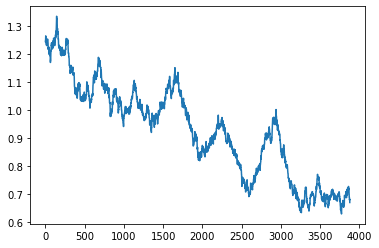

In [264]:
smoothed = []
window_size = 300
for i in range(window_size, len(train_losses)-window_size):
    smoothed.append(sum(train_losses[i:i+window_size])/window_size)
plt.plot(smoothed)

In [335]:
torch.save(model, "saved_model.pkl")

In [315]:
model_inference = torch.load("saved_model.pkl")

In [301]:
# Add Model Testing

In [278]:
model_inference = model

# Inference Test

In [321]:
# query = "how much does it cost to fly to boston"
# query = "what timezone is denver in"
# query = "show me the flights from new york to boston"
query = "how many flights are availble on tuesday"

query = query.lower().strip()
query = query.split()
query = map_token_sequence_to_ints(query)
query = torch.tensor(query, dtype=torch.long)

model_inference.eval()
pred = model_inference(query)
pred_class = pred.argmax(dim=-1).numpy()[0]

intent2int[pred_class]

'atis_quantity'

# Model Testing

In [326]:
test_intents_ints = list(map(lambda x: intent2int.index(x), test_intent_labels))
test_slots_ints   = list(map(map_label_sequence_to_ints, test_slot_labels))

In [327]:
test_token_tensors = []
test_slot_tensors = []
test_intent_tensors = []

for entry in test_data_ints:
    test_token_tensors.append(torch.tensor(entry, dtype=torch.long))

for entry in test_slots_ints:
    test_slot_tensors.append(torch.tensor(entry, dtype=torch.long))

for intent in test_intents_ints:
    test_intent_tensors.append(torch.tensor(intent, dtype=torch.long))

In [328]:
test_token_tensors[0], test_slot_tensors[0], test_intent_tensors[0]

(tensor([ 46, 185, 194, 309,  58, 760,  95, 715, 518, 309, 788, 102, 171, 689,
         760, 204, 665, 737,   5]),
 tensor([126, 126, 126, 126, 126, 126, 126, 126,  48, 126,  78, 123, 126, 126,
         126, 126, 126,  71, 119]),
 tensor(10))

In [334]:
model.eval()
intent_correct = 0
for i in range(len(test_intent_tensors)):
        model.zero_grad()
        print("\r", f"{i}/{len(test_intent_tensors)}", end="")
        x = test_token_tensors[i]
        # y_slot = train_slot_tensors[i]
        y_intent = test_intent_tensors[i].item()

        pred = model(x)
        pred_class = pred.argmax(dim=-1).numpy()[0]

        if pred_class == y_intent:
            intent_correct += 1
print()
print(intent_correct / len(test_intent_tensors))

 892/893
0.9507278835386338
